In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
import keras
from keras import layers
from keras.layers import *
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
from matplotlib import pyplot as plt
from PIL import Image
from scipy.io import loadmat

In [3]:
data = loadmat('jaffe_mean_data.mat')['jaffe_mean_data']

In [4]:
data = data.reshape((181,256,256,1))

In [5]:
label = loadmat('cl_label.mat')['cl_label']

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.2,random_state=0)

In [7]:
print('Training: ',X_train.shape)

Training:  (144, 256, 256, 1)


In [8]:
from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D

In [9]:
from keras.models import Sequential

In [10]:
def get_nn_model():
    model = Sequential()
    model.add(MaxPooling2D(pool_size = (4,4), strides=None,input_shape=(256,256,1)))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(Dropout(0.5))

    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [11]:
def get_cnn_model():
    model = Sequential()
    model.add(Convolution2D(64, (3, 3), padding='same',input_shape=(256,256,1)))
    model.add(Convolution2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, (3, 3), padding='same'))
    model.add(Convolution2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(256, (3, 3), padding='same'))
    model.add(Convolution2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(512, (3, 3), padding='same'))
    model.add(Convolution2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [12]:
cnn_model = get_cnn_model()

In [13]:
nn_model = get_nn_model()

In [14]:
from keras.preprocessing.image import ImageDataGenerator

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [16]:
from keras import backend as K

In [17]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 1

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

In [18]:
def train_cnn_model(model):
    filepath='../opt/jaffe-cnn/Model.{epoch:02d}-{val_acc:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,   # randomly flip images
        )


    datagen.fit(X_train)
    datagen.fit(X_test)    
    batch_size = 32

    num_epochs = 200
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=[fbeta, 'acc'])
    train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size)
    validation_flow = datagen.flow(X_test, Y_test)
    history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=validation_flow, 
                    validation_steps=len(X_test) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    return history, model

In [19]:
def train_nn_model(model):
    filepath='../opt/jaffe-nn/Model.{epoch:02d}-{val_acc:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,   # randomly flip images
        )


    datagen.fit(X_train)
    datagen.fit(X_test)    
    batch_size = 32

    num_epochs = 200
    model.compile(loss='categorical_crossentropy',
             optimizer='sgd',
             metrics=[fbeta, 'acc'])
    train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size)
    validation_flow = datagen.flow(X_test, Y_test)
    history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=validation_flow, 
                    validation_steps=len(X_test) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    return history, model

In [20]:
cnn_history, cnn_model = train_cnn_model(cnn_model)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
5/4 [=================================] - ETA: 0s - loss: 3.0845 - fbeta: 0.1000 - acc: 0.1319
Epoch 00001: saving model to ../opt/jaffe-cnn/Model.01-0.1622.hdf5

Epoch 00001: saving model to ../opt/jaffe-cnn/Model.01-0.1622.hdf5
5/4 [=================================] - 5s 904ms/step - loss: 3.0845 - fbeta: 0.1000 - acc: 0.1319 - val_loss: 2.6803 - val_fbeta: 0.0313 - val_acc: 0.1622
Epoch 2/200
5/4 [=================================] - ETA: 0s - loss: 2.4548 - fbeta: 0.0938 - acc: 0.2153
Epoch 00002: saving model to ../opt/jaffe-cnn/Model.02-0.1622.hdf5

Epoch 00002: saving model to ../opt/jaffe-cnn/Model.02-0.1622.hdf5
5/4 [=================================] - 2s 387ms/step - loss: 2.4548 - fbeta: 0.0938 - acc: 0.2153 - val_loss: 5.6849 - val_fbeta: 0.0781 - val_acc: 0.1622
Epoch 3/200
5/4 [=================================] - ETA: 0s - loss: 1.9753 - fbeta: 0.1563 - acc: 0.2708
Epoch 00003: savi

In [22]:
nn_history, nn_model = train_nn_model(nn_model)

Epoch 1/200
1/4 [=====>........................] - ETA: 0s - loss: 2.6844 - fbeta: 0.0313 - acc: 0.1562
Epoch 00001: saving model to ../opt/jaffe-nn/Model.01-0.1081.hdf5

Epoch 00001: saving model to ../opt/jaffe-nn/Model.01-0.1081.hdf5
5/4 [=================================] - 0s 53ms/step - loss: 2.5393 - fbeta: 0.0438 - acc: 0.1806 - val_loss: 1.9833 - val_fbeta: 2.0000e-07 - val_acc: 0.1081
Epoch 2/200
1/4 [=====>........................] - ETA: 0s - loss: 2.1874 - fbeta: 0.0625 - acc: 0.2188
Epoch 00002: saving model to ../opt/jaffe-nn/Model.02-0.1622.hdf5

Epoch 00002: saving model to ../opt/jaffe-nn/Model.02-0.1622.hdf5
5/4 [=================================] - 0s 15ms/step - loss: 2.0495 - fbeta: 0.1188 - acc: 0.3056 - val_loss: 1.9853 - val_fbeta: 2.0000e-07 - val_acc: 0.1622
Epoch 3/200
1/4 [=====>........................] - ETA: 0s - loss: 2.1414 - fbeta: 0.2188 - acc: 0.2812
Epoch 00003: saving model to ../opt/jaffe-nn/Model.03-0.1892.hdf5

Epoch 00003: saving model to ../o

In [23]:
n_classes = label.shape[1]

In [24]:
labels=range(n_classes)

In [25]:
def eval_model(history, model):
    batch_size = 32
    score = model.evaluate(X_test, Y_test, steps=(int)(len(X_test) / batch_size))
    print('Evaluation loss: ', score[0])
    print('Evaluation accuracy: ', score[1])
    # summarize history for accuracy
    plt.plot(history.history['acc'], color='b', label='Training')
    plt.plot(history.history['val_acc'], color='g', label='Validation')
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color='b', label='Training')
    plt.plot(history.history['val_loss'], color='g', label='Validation')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='lower left')
    plt.show()
    y_pred = model.predict_classes(X_test)
    y_true = np.asarray([np.argmax(i) for i in Y_test])

    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)
    cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.set(font_scale=1.5) 
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False, 
                        cmap="Greens", yticklabels=labels, xticklabels=labels, vmin=0, vmax=np.max(cm_normalised), 
                        fmt=".2f", annot_kws={"size": 20})
    ax.set(xlabel='Predicted label', ylabel='True label')

1/1 [==============================] - 0s 28ms/step - loss: 0.4904 - fbeta: 0.8108 - acc: 0.8378
Evaluation loss:  0.4904440939426422
Evaluation accuracy:  0.8108108043670654


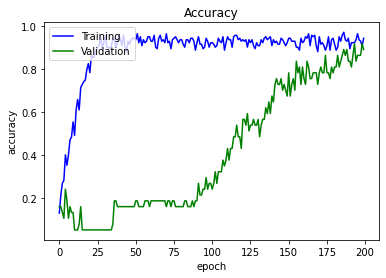

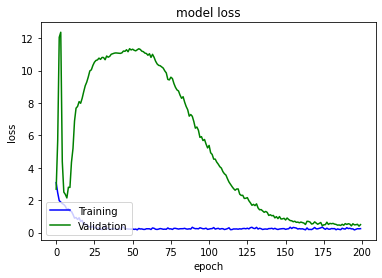

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


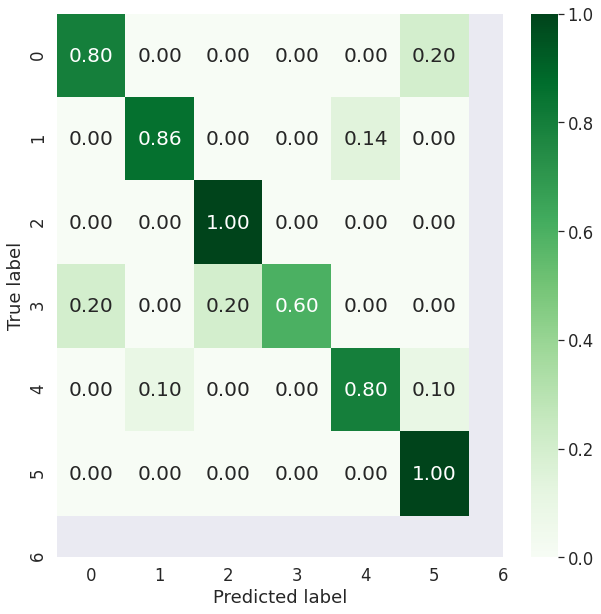

In [26]:
eval_model(cnn_history, cnn_model)

1/1 [==============================] - 0s 2ms/step - loss: 0.4088 - fbeta: 0.8919 - acc: 0.8919
Evaluation loss:  0.4088309407234192
Evaluation accuracy:  0.8918918967247009


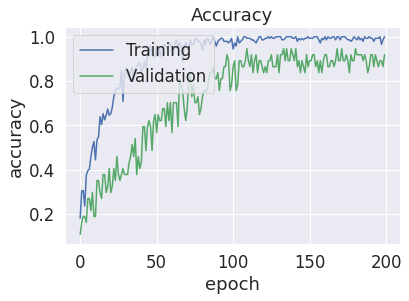

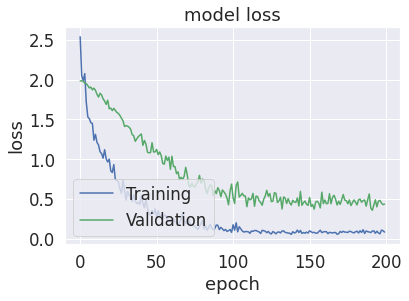

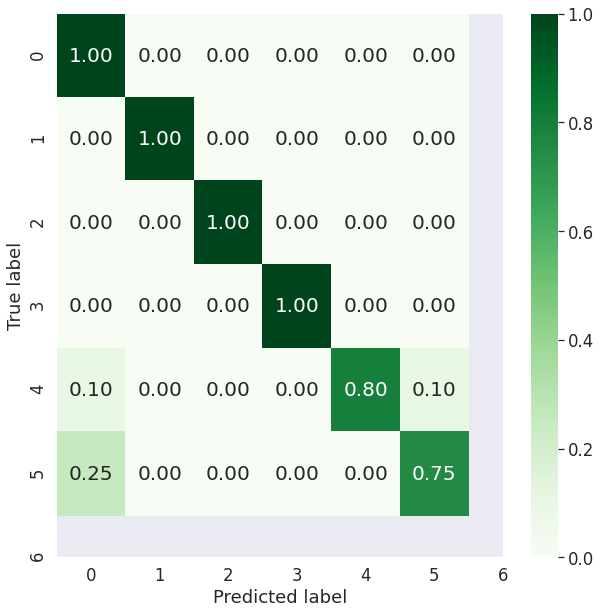

In [27]:
eval_model(nn_history, nn_model)